#  Next Location Suggestion for a new shopping center for the owner of Europa Passage in Hamburg

### Importing necessary libraries

In [341]:
import pandas as pd
import numpy as np
import folium
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim
import geocoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import requests 
from pandas import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Loading data for population and area of regions in Hamburg based on the postal code

In [283]:
hamburg_post_pop = pd.read_html('https://postal-codes.cybo.com/germany/hamburg/')[1]

In [284]:
hamburg_post_pop.head()

,Postal Code,City,Administrative Region,Population,Area
0,20038,Hamburg,Hamburg,—,—
1,20095,Hamburg,Hamburg,3574,0.855 km²
2,20097,Hamburg,Hamburg,12023,2.179 km²
3,20099,Hamburg,Hamburg,4612,1.49 km²
4,20144,Hamburg,Hamburg,5893,1.196 km²


In [285]:
# including only necessary columns
hamburg_post_pop = hamburg_post_pop[['Postal Code', 'Population', 'Area']]

In [286]:
hamburg_post_pop.head()

,Postal Code,Population,Area
0,20038,—,—
1,20095,3574,0.855 km²
2,20097,12023,2.179 km²
3,20099,4612,1.49 km²
4,20144,5893,1.196 km²


In [287]:
print("Number of postal codes in hamburg_post_pop: ", hamburg_post_pop.shape[0])

Number of postal codes in hamburg_post_pop:  102


#### removing the rows containing invalid values in the column Area

In [288]:
invalid_rows = []
for i in range(hamburg_post_pop.shape[0]):
    try:
        hamburg_post_pop.loc[i, 'Area'] = float(hamburg_post_pop.loc[i, 'Area'].split('km')[0])
    except:
        invalid_rows.append(i)
invalid_rows

[0, 8]

In [289]:
hamburg_post_pop.drop(index=invalid_rows, inplace=True)
hamburg_post_pop.reset_index(drop=True, inplace=True)

In [290]:
print("Number of postal codes in hamburg_post_pop: ", hamburg_post_pop.shape[0])

Number of postal codes in hamburg_post_pop:  100


In [291]:
hamburg_post_pop.head()

,Postal Code,Population,Area
0,20095,3574,0.855
1,20097,12023,2.179
2,20099,4612,1.49
3,20144,5893,1.196
4,20146,4402,1


In [292]:
hamburg_post_pop['Area'] = hamburg_post_pop['Area'].astype('float')
hamburg_post_pop['Population'] = hamburg_post_pop['Population'].astype('int')
hamburg_post_pop.dtypes

Postal Code      int64
Population       int64
Area           float64
dtype: object

### Loading latitude and longitude of each postal code

In [293]:
hamburg_post_latlong = pd.read_html('https://www.geonames.org/postalcode-search.html?q=&country=DE&adminCode1=HH')[2]

In [294]:
hamburg_post_latlong.head()

,Unnamed: 0,Place,Code,Country,Admin1,Admin2,Admin3,Admin4
0,1.0,Hamburg,20095,Germany,Hamburg,NaN,"Hamburg, Freie und Hansestadt","Hamburg, Freie und Hansestadt"
1,NaN,53.552/10,53.552/10,53.552/10,53.552/10,53.552/10,53.552/10,53.552/10
2,2.0,Hamburg,20097,Germany,Hamburg,NaN,"Hamburg, Freie und Hansestadt","Hamburg, Freie und Hansestadt"
3,NaN,53.548/10.019,53.548/10.019,53.548/10.019,53.548/10.019,53.548/10.019,53.548/10.019,53.548/10.019
4,3.0,Hamburg,20099,Germany,Hamburg,NaN,"Hamburg, Freie und Hansestadt","Hamburg, Freie und Hansestadt"


In [295]:
# keepig only necessary columns
hamburg_post_latlong = hamburg_post_latlong[['Unnamed: 0', 'Place','Code']]

In [296]:
hamburg_post_latlong.head(10)

,Unnamed: 0,Place,Code
0,1.0,Hamburg,20095
1,NaN,53.552/10,53.552/10
2,2.0,Hamburg,20097
3,NaN,53.548/10.019,53.548/10.019
4,3.0,Hamburg,20099
5,NaN,53.558/10.011,53.558/10.011
6,4.0,Hamburg,20146
7,NaN,53.567/9.98,53.567/9.98
8,5.0,Hamburg,20148
9,NaN,53.567/9.998,53.567/9.998


#### As you may see, on the odd rows are the location coordinates and on the even ones the postal codes
#### meaning we need a little bit data cleaning and preparation

In [297]:
hamburg_post_latlong.shape

(401, 3)

In [298]:
hamburg_post_latlong.tail()

,Unnamed: 0,Place,Code
396,199.0,Hamburg Eppendorf,22529
397,NaN,53.589/9.981,53.589/9.981
398,200.0,Hamburg Lurup,22549
399,NaN,53.594/9.874,53.594/9.874
400,NaN,NaN,NaN


In [299]:
hamburg_post_latlong.drop(index=[400],inplace=True)

In [300]:
lat = []
long = []
Code = []
hamburg_latlong_cleaned = pd.DataFrame(columns=['Postal Code', 'Latitude', 'Longitude'])
for i in range(0, hamburg_post_latlong.shape[0], 2):
    Code.append(hamburg_post_latlong.loc[i,'Code'])
    lt, lg = hamburg_post_latlong.loc[i+1, 'Place'].split('/')
    lat.append(float(lt))
    long.append(float(lg))
hamburg_latlong_cleaned = pd.DataFrame(list(zip(Code, lat, long)), columns = ['Postal Code', 'Latitude', 'Longitude'])

In [301]:
print(hamburg_latlong_cleaned.shape)
hamburg_latlong_cleaned['Postal Code'] = hamburg_latlong_cleaned['Postal Code'].astype('int')
hamburg_latlong_cleaned.head(10)

(200, 3)


,Postal Code,Latitude,Longitude
0,20095,53.552,10.000
1,20097,53.548,10.019
2,20099,53.558,10.011
3,20146,53.567,9.980
4,20148,53.567,9.998
5,20354,53.557,9.990
6,20357,53.564,9.968
7,20457,53.534,9.981
8,20459,53.550,9.984
9,22525,53.592,9.920


In [302]:
hamburg_latlong_cleaned.dtypes

Postal Code      int64
Latitude       float64
Longitude      float64
dtype: object

In [303]:
len(hamburg_latlong_cleaned['Postal Code'].unique())

99

In [304]:
hamburg_latlong_cleaned.drop_duplicates(subset=['Postal Code'], keep='first', inplace=True)
hamburg_latlong_cleaned.head()

,Postal Code,Latitude,Longitude
0,20095,53.552,10.000
1,20097,53.548,10.019
2,20099,53.558,10.011
3,20146,53.567,9.980
4,20148,53.567,9.998


In [305]:
len(hamburg_post_pop['Postal Code'].unique())

100

In [306]:
for i in range(hamburg_post_pop['Postal Code'].shape[0]):
    if hamburg_post_pop.loc[i, 'Postal Code'] not in list(hamburg_latlong_cleaned['Postal Code']):
        print(i)

48


In [307]:
hamburg_post_pop.drop(index=[48], inplace=True)

In [308]:
hamburg_post_pop.reset_index(drop=True, inplace=True)

In [309]:
# df is the main project-based dataframe
df = pd.merge(hamburg_post_pop, hamburg_latlong_cleaned, on='Postal Code')

In [310]:
df.head()

,Postal Code,Population,Area,Latitude,Longitude
0,20095,3574,0.855,53.552,10.000
1,20097,12023,2.179,53.548,10.019
2,20099,4612,1.490,53.558,10.011
3,20144,5893,1.196,53.574,9.975
4,20146,4402,1.000,53.567,9.980


In [311]:
df.shape

(99, 5)

In [312]:
df.dtypes

Postal Code      int64
Population       int64
Area           float64
Latitude       float64
Longitude      float64
dtype: object

In [313]:
latitude = df['Latitude'].mean()
longitude = df['Longitude'].mean()
map_hamburg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, postal_code in zip(df['Latitude'], df['Longitude'], df['Postal Code']):
    label = str(postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg)  
    
map_hamburg

In [314]:
CLIENT_ID = 'the client ID'
CLIENT_SECRET = 'the client secret'
VERSION = '20180602'
LIMIT = 100

In [317]:
# a function to explore locations in a given radius for each postal code
def getNearbyVenues(postalcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pcode, lat, lng in zip(postalcodes, latitudes, longitudes):
        print(pcode, '...')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Nearby venues are imported.')
    return(nearby_venues)

In [318]:
hamburg_venues = getNearbyVenues(postalcodes=df['Postal Code'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

20095 ...
20097 ...
20099 ...
20144 ...
20146 ...
20148 ...
20149 ...
20249 ...
20251 ...
20253 ...
20255 ...
20257 ...
20259 ...
20354 ...
20355 ...
20357 ...
20359 ...
20457 ...
20459 ...
20535 ...
20537 ...
20539 ...
21029 ...
21031 ...
21033 ...
21035 ...
21037 ...
21039 ...
21073 ...
21075 ...
21077 ...
21079 ...
21107 ...
21109 ...
21129 ...
21147 ...
21149 ...
22041 ...
22043 ...
22045 ...
22047 ...
22049 ...
22081 ...
22083 ...
22085 ...
22087 ...
22089 ...
22111 ...
22115 ...
22117 ...
22119 ...
22143 ...
22145 ...
22147 ...
22149 ...
22159 ...
22175 ...
22177 ...
22179 ...
22297 ...
22299 ...
22301 ...
22303 ...
22305 ...
22307 ...
22309 ...
22335 ...
22337 ...
22339 ...
22359 ...
22391 ...
22393 ...
22395 ...
22397 ...
22399 ...
22415 ...
22417 ...
22419 ...
22453 ...
22455 ...
22457 ...
22459 ...
22523 ...
22525 ...
22527 ...
22529 ...
22547 ...
22549 ...
22559 ...
22587 ...
22589 ...
22605 ...
22607 ...
22609 ...
22761 ...
22763 ...
22765 ...
22767 ...
22769 ...
Nearby ven

#### The size of Hamburg's venues data frame

In [319]:
hamburg_venues.shape

(1928, 7)

In [320]:
hamburg_venues.head(10)

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20095,53.552,10.0,Thalia Theater,53.552000,9.998338,Theater
1,20095,53.552,10.0,Sakura Sushi,53.552442,10.000058,Sushi Restaurant
2,20095,53.552,10.0,Tschebull,53.551419,10.003052,Austrian Restaurant
3,20095,53.552,10.0,Passage Kino,53.550708,9.998299,Indie Movie Theater
4,20095,53.552,10.0,Nachtasyl,53.551972,9.998253,Nightclub
5,20095,53.552,10.0,Park Hyatt Hamburg,53.550977,10.003158,Hotel
6,20095,53.552,10.0,Shiso Burger,53.550648,10.001897,Burger Joint
7,20095,53.552,10.0,MAC Cosmetics,53.551543,10.003027,Cosmetics Shop
8,20095,53.552,10.0,cohibar,53.552515,10.000687,Hookah Bar
9,20095,53.552,10.0,Die Rösterei,53.549879,10.001518,Coffee Shop


### Number of venues per postal code

In [321]:
hamburg_venues_count_grouped = hamburg_venues.groupby('Postal Code').count().reset_index()

In [322]:
hamburg_venues_count_grouped.shape

(95, 7)

In [323]:
hamburg_venues_count_grouped.head()

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,20095,90,90,90,90,90,90
1,20097,17,17,17,17,17,17
2,20099,92,92,92,92,92,92
3,20144,21,21,21,21,21,21
4,20146,41,41,41,41,41,41


#### Number of unique categories

In [324]:
len(hamburg_venues['Venue Category'].unique())

276

In [325]:
hamburg_onehot = pd.get_dummies(hamburg_venues[['Venue Category']], prefix="", prefix_sep="")

hamburg_onehot['Postal Code'] = hamburg_venues['Postal Code']

In [326]:
hamburg_onehot.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bavarian Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat Rental,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swabian Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit,Postal Code
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [327]:
hamburg_postalcode_venues_grouped = hamburg_onehot.groupby('Postal Code').mean().reset_index()
hamburg_postalcode_venues_grouped.head()


,Postal Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bavarian Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat Rental,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swabian Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,20095,0.000000,0.0,0.0,0.00000,0.000000,0.011111,0.0,0.00000,0.0,0.011111,0.0,0.011111,0.00000,0.011111,0.0,0.0,0.0,0.0,0.011111,0.0,0.03

In [328]:
categs = hamburg_postalcode_venues_grouped.columns


In [329]:
hamburg_postalcode_venues_grouped.shape

(95, 277)

In [330]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [331]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = hamburg_postalcode_venues_grouped['Postal Code']

for ind in np.arange(hamburg_postalcode_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hamburg_postalcode_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20095,Vietnamese Restaurant,Cosmetics Shop,Café,Bookstore,Drugstore,Burger Joint,Bakery,Hotel,Plaza,Electronics Store
1,20097,Hotel,ATM,Asian Restaurant,Coffee Shop,Café,Soup Place,Bed & Breakfast,Bar,Bakery,Pizza Place
2,20099,Hotel,Restaurant,Indian Restaurant,Supermarket,Burger Joint,French Restaurant,Hotel Bar,Italian Restaurant,Café,Pub
3,20144,Indian Restaurant,Restaurant,Breakfast Spot,Italian Restaurant,Bank,Bakery,Taverna,Café,Steakhouse,Drugstore
4,20146,Café,Bakery,Italian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Coffee Shop,Cocktail Bar,Tea Room,Burger Joint,Electronics Store


In [332]:
neigh_venues_grouped_extraInfo = pd.merge(hamburg_postalcode_venues_grouped, df[['Postal Code','Population','Area']], on='Postal Code')
neigh_venues_grouped_extraInfo.shape

(95, 279)

In [333]:
neigh_venues_grouped_extraInfo.head()

,Postal Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bavarian Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat Rental,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swabian Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit,Population,Area
0,20095,0.000000,0.0,0.0,0.00000,0.000000,0.011111,0.0,0.00000,0.0,0.011111,0.0,0.011111,0.00000,0.011111,0.0,0.0,0.0,0.0,0

In [334]:
# because we want to keep track of postal codes, we insert them as index
categs=neigh_venues_grouped_extraInfo.columns[1:]
postalcodes = neigh_venues_grouped_extraInfo['Postal Code']
neigh_venues_grouped_extraInfo.set_index('Postal Code', inplace=True)

### Standardazing the data due to their different original scale

In [335]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
neigh_venues_grouped_extraInfo = scaler.fit_transform(neigh_venues_grouped_extraInfo)

In [336]:
hamburg_df = pd.DataFrame(neigh_venues_grouped_extraInfo, columns=categs)

In [337]:
hamburg_df.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bavarian Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat Rental,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swabian Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit,Population,Area
0,-0.103142,-0.145852,-0.103142,-0.103142,-0.103142,0.248036,-0.103142,-0.103142,-0.108271,9.695360,-0.186204,0.227723,-0.163658,1.6409

In [338]:
hamburg_df.set_index(postalcodes, inplace=True)

In [339]:
hamburg_df.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bavarian Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat Rental,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Café,Canal,Candy Store,Cantonese Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swabian Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit,Population,Area
Postal Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

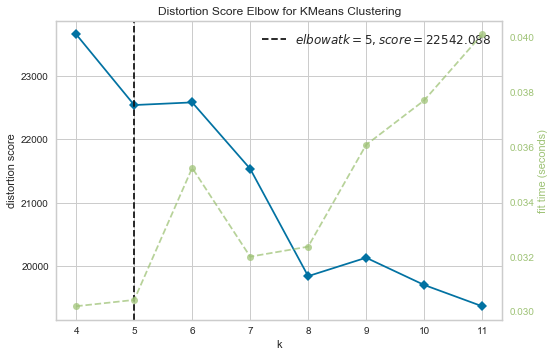

In [398]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), locate_elbow=True)

visualizer.fit(hamburg_df)        # Fit the data to the visualizer
visualizer.show()

In [469]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=9).fit(hamburg_df)

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
if 'Cluster Labels' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



neighborhoods_venues_sorted['Cluster Labels']=neighborhoods_venues_sorted['Cluster Labels'].astype('int')
neighborhoods_venues_sorted.head(20)


,Cluster Labels,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,20095,Vietnamese Restaurant,Cosmetics Shop,Café,Bookstore,Drugstore,Burger Joint,Bakery,Hotel,Plaza,Electronics Store
1,4,20097,Hotel,ATM,Asian Restaurant,Coffee Shop,Café,Soup Place,Bed & Breakfast,Bar,Bakery,Pizza Place
2,4,20099,Hotel,Restaurant,Indian Restaurant,Supermarket,Burger Joint,French Restaurant,Hotel Bar,Italian Restaurant,Café,Pub
3,4,20144,Indian Restaurant,Restaurant,Breakfast Spot,Italian Restaurant,Bank,Bakery,Taverna,Café,Steakhouse,Drugstore
4,4,20146,Café,Bakery,Italian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Coffee Shop,Cocktail Bar,Tea Room,Burger Joint,Electronics Store
5,4,20148,Italian Restaurant,Restaurant,Steakhouse,Café,Bar,Coffee Shop,Athletics & Sports,Spa,Music School,Mediterranean Restaurant
6,4,20149,Park,Hotel,Bookstore,Trail,Bar,Harbor / Marina,Bus Stop,Italian Restaurant,Bank,Food
7,4,20249,Italian Restaurant,Drugstore,Ice Cream Shop,Bakery,Coffee Shop,Supermarket,Fruit & Vegetable Store,Mediterranean Restaurant,Bistro,Gym
8,4,20251,Café,Italian Restaurant,Ice Cream Shop,Vietnamese Restaurant,Furniture / Home Store,German Restaurant,Wine Shop,Vegetarian / Vegan Restaurant,Restaurant,Bookstore
9,4,20253,Café,Furniture / Home Store,Pizza Place,Italian Restaurant,Ice Cream Shop,Supermarket,Sushi Restaurant,Bakery,Burger Joint,Gym / Fitness Center


In [470]:
list(neighborhoods_venues_sorted['Cluster Labels']).count(0)

3

In [471]:
hamburg_merged = neighborhoods_venues_sorted.set_index('Postal Code')
hamburg_merged = hamburg_merged.join(df.set_index('Postal Code'), on='Postal Code')
hamburg_merged.shape


(95, 15)

In [472]:
hamburg_merged['Cluster Labels'].isnull().sum()

0

In [473]:
hamburg_merged.dropna(axis=0, inplace=True)
hamburg_merged['Cluster Labels']=hamburg_merged['Cluster Labels'].astype('int')

In [474]:
hamburg_merged.head()

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population,Area,Latitude,Longitude
Postal Code,,,,,,,,,,,,,,,
20095,0,Vietnamese Restaurant,Cosmetics Shop,Café,Bookstore,Drugstore,Burger Joint,Bakery,Hotel,Plaza,Electronics Store,3574,0.855,53.552,10.000
20097,4,Hotel,ATM,Asian Restaurant,Coffee Shop,Café,Soup Place,Bed & Breakfast,Bar,Bakery,Pizza Place,12023,2.179,53.548,10.019
20099,4,Hotel,Restaurant,Indian Restaurant,Supermarket,Burger Joint,French Restaurant,Hotel Bar,Italian Restaurant,Café,Pub,4612,1.490,53.558,10.011
20144,4,Indian Restaurant,Restaurant,Breakfast Spot,Italian Restaurant,Bank,Bakery,Taverna,Café,Steakhouse,Drugstore,5893,1.196,53.574,9.975
20146,4,Café,Bakery,Italian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Coffee Shop,Cocktail Bar,Tea Room,Burger Joint,Electronics Store,4402,1.000,53.567,9.980


### As you see in the head of hamburg_merge dataframe, the postal code 20095 belongs to cluster 6 

In [475]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hamburg_merged['Latitude'], hamburg_merged['Longitude'], hamburg_merged.index, hamburg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0 where 20095 belongs to

In [477]:
cluster0 = hamburg_merged.loc[hamburg_merged['Cluster Labels'] == 0, hamburg_merged.columns[1:]]
cluster0

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population,Area,Latitude,Longitude
Postal Code,,,,,,,,,,,,,,
20095,Vietnamese Restaurant,Cosmetics Shop,Café,Bookstore,Drugstore,Burger Joint,Bakery,Hotel,Plaza,Electronics Store,3574,0.855,53.552,10.000
20355,Hotel,Restaurant,Gym / Fitness Center,Botanical Garden,Café,Burger Joint,Garden,Ramen Restaurant,Plaza,Playground,7564,1.423,53.557,9.980
22299,Café,Italian Restaurant,Drugstore,Trattoria/Osteria,Bus Stop,Vietnamese Restaurant,Bakery,Plaza,Bank,Bar,6460,1.708,53.596,10.002


In [478]:
hamburg_df_cluster0 = hamburg_df.loc[neighborhoods_venues_sorted.set_index('Postal Code')['Cluster Labels'] == 0,:]

In [481]:
from math import sqrt
centroid_0 = kmeans.cluster_centers_[0,:]
dist2centroid0_square = [sqrt(sum((hamburg_df_cluster0.loc[p,:]-centroid_1)**2)) for p in hamburg_df_cluster0.index]
dist2centroid0_abs = [sum(abs((hamburg_df_cluster0.loc[p,:]-centroid_0))) for p in hamburg_df_cluster0.index]
squareErrorDist = pd.DataFrame(dist2centroid0_square, index=hamburg_df_cluster0.index, columns=['sqErr'])
absoluteErrorDist = pd.DataFrame(dist2centroid0_abs, index=hamburg_df_cluster0.index, columns=['absErr'])


In [482]:
dist2centroid0_square20095 = [sqrt(sum((hamburg_df_cluster0.loc[p,:]-hamburg_df_cluster0.loc[20095,:])**2)) for p in hamburg_df_cluster0.index]
dist2centroid0_abs20095 = [sum(abs((hamburg_df_cluster0.loc[p,:]-hamburg_df_cluster0.loc[20095,:]))) for p in hamburg_df_cluster0.index]
squareErrorDistfrom20095 = pd.DataFrame(dist2centroid0_square20095, index=hamburg_df_cluster0.index, columns=['sqErr20095'])
absoluteErrorDistfrom20095 = pd.DataFrame(dist2centroid0_abs20095, index=hamburg_df_cluster0.index, columns=['absErr20095'])

cluster0_df_result = pd.concat([squareErrorDist, absoluteErrorDist,
                                squareErrorDistfrom20095, absoluteErrorDistfrom20095],
                              axis=1)
cluster0_df_result

,sqErr,absErr,sqErr20095,absErr20095
Postal Code,,,,
20095,44.716237,149.513921,0.000000,0.000000
20355,35.652246,125.289738,40.597462,246.197151
22299,36.237939,119.872773,39.823908,229.960976


Text(0.5, 1.0, 'Postal codes with almost the same squared error as 20095')

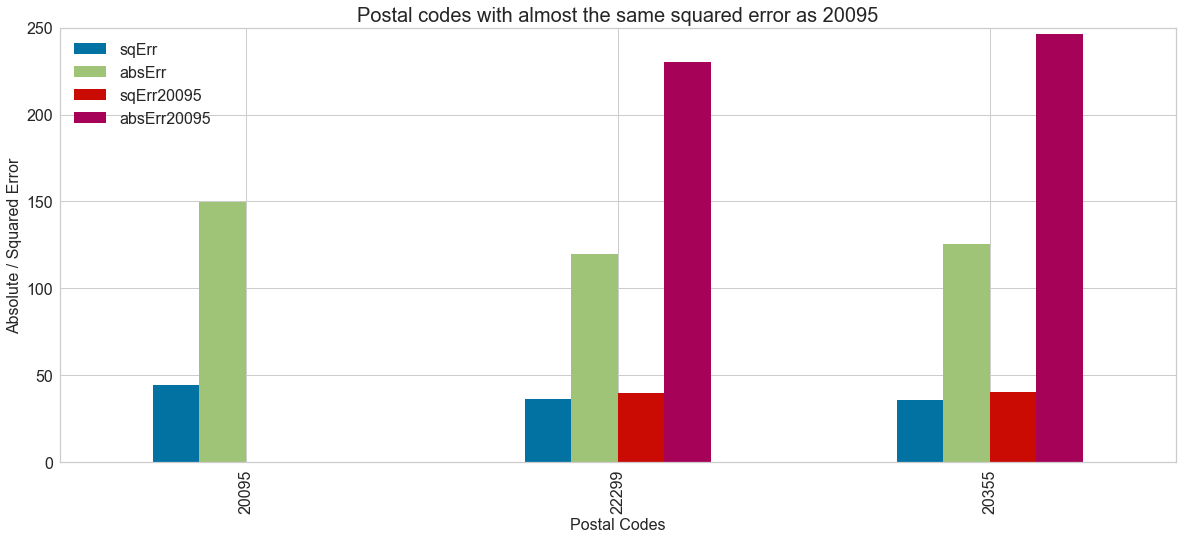

In [496]:
sqErrCandidates = cluster0_df_result.sort_values('sqErr20095',ascending=True).head(5)
ax1 = sqErrCandidates.plot(kind='bar', fontsize=16, figsize=(20,8))
ax1.legend(fontsize=16)
ax1.set_ylabel('Absolute / Squared Error', fontsize=16)
ax1.set_xlabel('Postal Codes', fontsize=16)
ax1.set_ylim(0,250)
ax1.set_title('Postal codes with almost the same squared error as 20095',fontsize=20)

## Europa Passage is located in the red circle. The two other blue circles are the suggestions of the model for the next shopping center

In [498]:
latitude = cluster1['Latitude'].mean()
longitude = cluster1['Longitude'].mean()
map_hamburg_result = folium.Map(location=[latitude, longitude], zoom_start=12)
ChosenPostalCodes = [p for p in sqErrCandidates.index if p !=20095]
for lat, lng, postal_code in zip(cluster1.loc[ChosenPostalCodes,'Latitude'], cluster1.loc[ChosenPostalCodes,'Longitude'],
                                 ChosenPostalCodes):
    label = str(postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg_result)

folium.CircleMarker(
        [cluster1.loc[20095,'Latitude'], cluster1.loc[20095,'Longitude']],
        radius=5,
        popup='20095 (Europa Passage)',
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg_result)  
    
map_hamburg_result